In [1]:
from pathlib import Path
from var_general_model import var_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


notebook_path = Path().resolve()
base_dir = notebook_path.parent

In [2]:
def calculate_implied_pd(cds_spread_bps, recovery_rate=0.4):
    """
    Hàm helper: Chuyển đổi CDS spread (đơn vị bps) thành Implied PD.
    """
    if recovery_rate >= 1 or recovery_rate < 0:
        raise ValueError("Recovery Rate phải nằm trong khoảng [0, 1).")
        
    cds_spread_decimal = cds_spread_bps / 10000.0
    implied_pd = cds_spread_decimal / (1 - recovery_rate)
    return implied_pd

def process_and_visualize_forecasts(pipeline_output, recovery_rate=0.4, cds_col='CDS_5Y_CS_1D'):
    """
    Xử lý kết quả dự báo, tính toán Implied PD và trực quan hóa.
    Hàm này xử lý đúng cho cả output của VAR (log-returns) và VECM (levels).
    """
    print("\n\n--- 4. DỰ BÁO CDS SPREAD VÀ IMPLIED PD ---")

    # Lấy các thành phần cần thiết từ output của pipeline
    model_type = pipeline_output.get('model_type', 'VAR')
    forecast_df = pipeline_output.get('forecast')
    df_full = pipeline_output.get('df_full')

    # --- 1. Kiểm tra điều kiện đầu vào ---
    if forecast_df is None or forecast_df.empty:
        print("Không có dữ liệu dự báo để xử lý.")
        return
    if cds_col not in forecast_df.columns:
        print(f"Lỗi: Không tìm thấy cột '{cds_col}' trong kết quả dự báo.")
        return
    if df_full is None or df_full.empty:
        print("Lỗi: Không tìm thấy 'df_full' để lấy giá trị gốc cuối cùng.")
        return

    # --- 2. Lấy chuỗi dự báo CDS Spread (đã ở mức gốc) ---
    if model_type == 'VECM':
        # VECM dự báo trực tiếp trên mức gốc (levels), không cần đảo ngược phép biến đổi
        print("Mô hình là VECM, sử dụng trực tiếp kết quả dự báo mức gốc.")
        forecasted_cds_spread = forecast_df[cds_col]
    else: # Mặc định là VAR
        # VAR dự báo trên log-returns, cần đảo ngược phép biến đổi
        print("Mô hình là VAR, thực hiện đảo ngược phép biến đổi từ log-returns.")
        try:
            # Lấy giá trị log của CDS cuối cùng từ dữ liệu gốc
            last_cds_value_log = np.log(df_full[cds_col].dropna().iloc[-1])
            
            # Lấy chuỗi log-returns dự báo
            forecasted_log_returns = forecast_df[cds_col]
            
            # Cộng dồn log-returns để có giá trị log trong tương lai
            forecasted_log_values = last_cds_value_log + forecasted_log_returns.cumsum()
            
            # Dùng hàm mũ để quay về giá trị gốc
            forecasted_cds_spread = np.exp(forecasted_log_values)
        except Exception as e:
            print(f"Lỗi khi đảo ngược phép biến đổi cho VAR: {e}")
            return
            
    forecasted_cds_spread.name = 'Forecasted_CDS_Spread_bps'

    # --- 3. Tính toán Implied PD ---
    forecasted_pd = calculate_implied_pd(forecasted_cds_spread, recovery_rate=recovery_rate)
    forecasted_pd.name = 'Implied_PD'

    # --- 4. Tạo DataFrame kết quả cuối cùng và in ---
    final_prediction_df = pd.concat([forecasted_cds_spread, forecasted_pd], axis=1)
    print(f"\nBảng dự báo CDS Spread và Implied PD (giả định Recovery Rate = {recovery_rate:.0%})")
    print(final_prediction_df.head().to_string())

    # --- 5. Trực quan hóa kết quả ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Vẽ CDS Spread
    color = 'tab:blue'
    ax1.set_xlabel('Ngày')
    ax1.set_ylabel('Dự báo CDS Spread (bps)', color=color)
    ax1.plot(final_prediction_df.index, final_prediction_df['Forecasted_CDS_Spread_bps'], color=color, marker='.', linestyle='--', label='CDS Spread')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Tạo trục y thứ hai cho Implied PD
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Dự báo Implied PD (%)', color=color)
    ax2.plot(final_prediction_df.index, final_prediction_df['Implied_PD'] * 100, color=color, marker='.', linestyle=':', label='Implied PD')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Dự báo CDS Spread và Xác suất Vỡ nợ (Implied PD) của Credit Suisse', fontsize=16)
    fig.tight_layout()
    plt.show()

def format_and_print_results(pipeline_output):
    """
    Hàm này nhận output từ var_pipeline và in ra kết quả
    một cách có cấu trúc và dễ đọc.
    """
    if not pipeline_output:
        print("Pipeline không trả về kết quả.")
        return

    # Lấy các kết quả chính từ output
    model_type = pipeline_output.get('model_type', 'Không xác định')
    results = pipeline_output.get('results')
    forecast_df = pipeline_output.get('forecast')
    final_exogs = pipeline_output.get('final_exogs', [])

    print("="*80)
    print(f"               KẾT QUẢ PHÂN TÍCH MÔ HÌNH {model_type.upper()}")
    print("="*80)

    # --- 1. In tóm tắt mô hình ---
    if results:
        print("\n--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---")
        print(f"Mô hình được lựa chọn tự động là: {model_type}")
        print("\nBảng tóm tắt các hệ số và thống kê mô hình:")
        print(results.summary())
    else:
        print("\n--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---")
        print("Không có kết quả mô hình để hiển thị.")

    # --- 2. In bảng dự báo ---
    if forecast_df is not None and not forecast_df.empty:
        print("\n\n--- 2. BẢNG DỰ BÁO CHO CÁC BIẾN NỘI SINH ---")
        print(f"Dưới đây là dự báo cho {len(forecast_df)} bước thời gian tiếp theo:")
        # Sử dụng to_string() để format đẹp hơn trong terminal/notebook
        print(forecast_df.head().to_string())
        if len(forecast_df) > 5:
            print("...")
    else:
        print("\n\n--- 2. BẢNG DỰ BÁO CHO CÁC BIẾN NỘI SINH ---")
        print("Không có dữ liệu dự báo được tạo ra.")

    # --- 3. In danh sách biến ngoại sinh cuối cùng ---
    print("\n\n--- 3. DANH SÁCH BIẾN NGOẠI SINH CUỐI CÙNG ---")
    if final_exogs:
        print("Các biến ngoại sinh được sử dụng trong mô hình sau khi xử lý (PCA, Granger,...):")
        # In 5 biến trên mỗi dòng cho dễ nhìn
        for i in range(0, len(final_exogs), 5):
            print("  - " + ", ".join(final_exogs[i:i+5]))
    else:
        print("Mô hình không sử dụng biến ngoại sinh nào.")
        
    print("\n" + "="*80)

In [3]:
# Thử nghiệm trên khoảng thời gian khủng hoảng của Credit Suisse sau sự kiện Greensill (từ tháng 1/2021 - 4/2021)
pipeline_output = var_pipeline(data_root = base_dir, VNIndex = False, use_granger_selection= True)


=== Tổng quan biến ===
Endogenous (market, original levels): ['CBOE_Volatility_Index_FRED', 'CDS_5Y_CS_1D', 'PRICE_CS_1D', 'SX7E_STOXX_Banks_EUR_Price']
Candidate exogenous variables: ['Provision for credit losses', 'Non-accrual loans / Gross loans', 'Gross impaired loans / Gross loans', 'Allowance for credit losses / Gross loans', 'Loan-to-Deposit Ratio (LDR)', 'Liquidity Coverage Ratio (LCR)', 'CET1 ratio', 'Tier 1 leverage ratio', 'Cost/income ratio', 'Return on Equity (ROE)', 'ECB_RATE', 'FED_FUNDS', 'ECONOMICS_-USCPI-1D', 'ECONOMICS_CHCPI-1D', 'ECONOMICS_CHGDPCP_1D', 'ECONOMICS_EUCPI-1D', 'ECONOMICS_EUGDPCP_1D', 'ECONOMICS_USGDPCP_1D', 'total_mark']

Dừng: ['Allowance for credit losses / Gross loans', 'CBOE_Volatility_Index_FRED', 'total_mark']

Không dừng: ['Provision for credit losses', 'Non-accrual loans / Gross loans', 'Gross impaired loans / Gross loans', 'Loan-to-Deposit Ratio (LDR)', 'Liquidity Coverage Ratio (LCR)', 'CET1 ratio', 'Tier 1 leverage ratio', 'Cost/income rati

In [4]:
format_and_print_results(pipeline_output)

               KẾT QUẢ PHÂN TÍCH MÔ HÌNH VECM

--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---
Mô hình được lựa chọn tự động là: VECM

Bảng tóm tắt các hệ số và thống kê mô hình:
   Det. terms outside the coint. relation & lagged endog. parameters for equation CDS_5Y_CS_1D   
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
exog1                            -0.2790      0.742     -0.376      0.707      -1.733       1.175
exog2                             0.5033      1.074      0.468      0.639      -1.603       2.609
exog3                            -0.1823      0.573     -0.318      0.750      -1.306       0.941
L1.CDS_5Y_CS_1D                   0.0145      0.031      0.474      0.636      -0.045       0.074
L1.PRICE_CS_1D                   -1.0327      7.011     -0.147      0.883     -14.775      12.709
L1.SX7E_STOXX_Banks_EUR_Price     2.7018      0.87



--- 4. DỰ BÁO CDS SPREAD VÀ IMPLIED PD ---
Mô hình là VECM, sử dụng trực tiếp kết quả dự báo mức gốc.

Bảng dự báo CDS Spread và Implied PD (giả định Recovery Rate = 40%)
            Forecasted_CDS_Spread_bps  Implied_PD
2023-07-01                 102.614851    0.017102
2023-07-02                 103.191144    0.017199
2023-07-03                 110.580314    0.018430
2023-07-04                 113.151684    0.018859
2023-07-05                 117.651825    0.019609


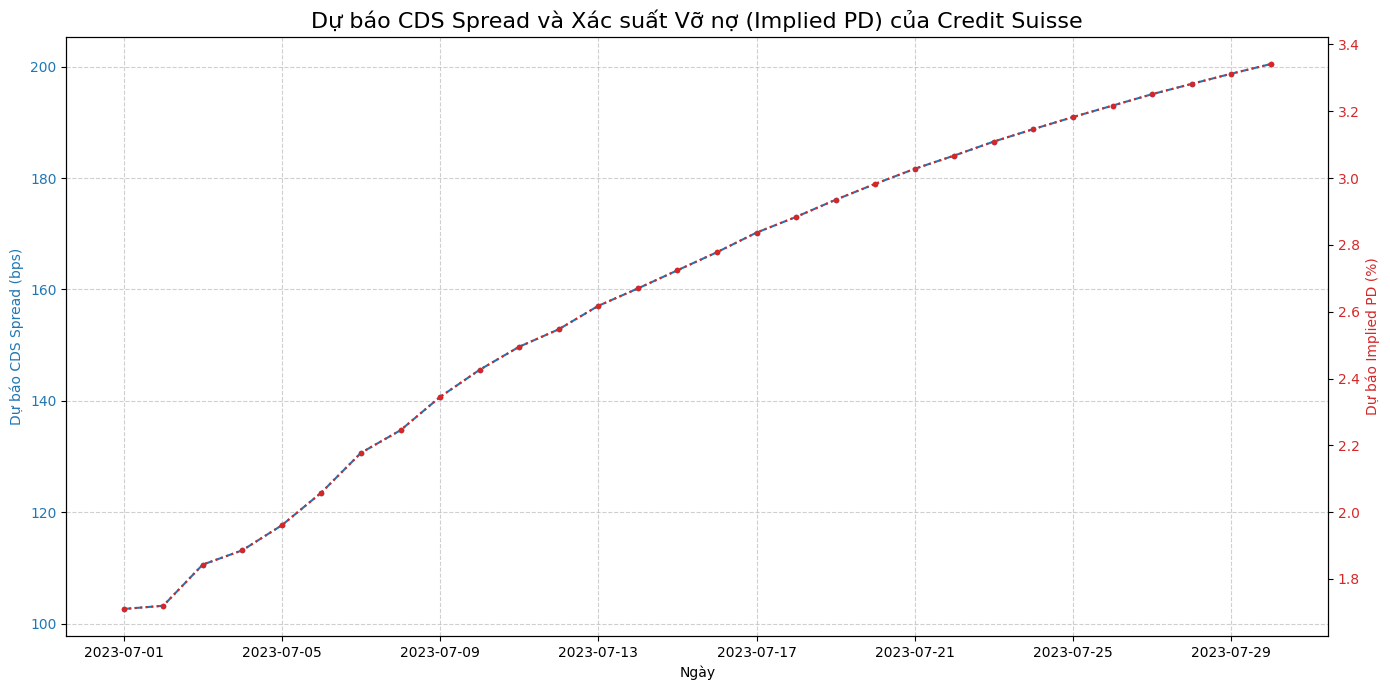

In [5]:
process_and_visualize_forecasts(pipeline_output, recovery_rate=0.4)